In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split


X = pd.read_csv("Student_Performance.csv")

In [131]:
X.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [132]:
X["Extracurricular Activities"] = X["Extracurricular Activities"].map(lambda x: 1 if x == "Yes" else 0)
X.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


<Axes: >

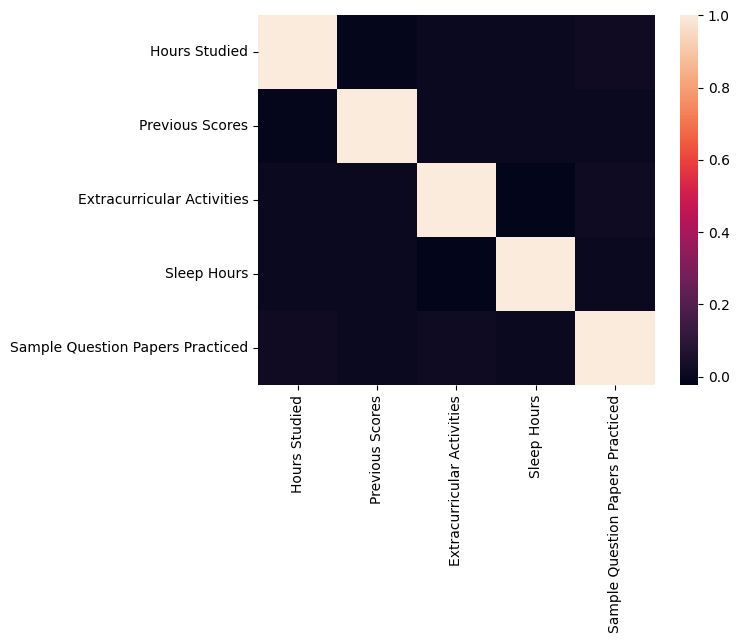

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(X.corr())#sad picture

In [134]:
y = X.pop("Performance Index")
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 42)

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

num_cols = [x for x in X_train.columns if X_train[x].dtype in [ "float64", "int64"]]

preprocessor = ColumnTransformer(
    transformers=([ ('num', StandardScaler(), num_cols)]))

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())
                             ])

In [136]:
my_pipeline.fit(X_train, y_train)
preds = my_pipeline.predict(X_test)

print(f"baseline linreg MSE: {mse(y_test, preds)}")

baseline linreg MSE: 4.082628398521845


In [137]:
coefs = my_pipeline["model"].coef_
list(zip(coefs, X_train.columns))

[(7.401340794046573, 'Hours Studied'),
 (17.63727126717766, 'Previous Scores'),
 (0.304290755963921, 'Extracurricular Activities'),
 (0.8100310701229987, 'Sleep Hours'),
 (0.5488417139901891, 'Sample Question Papers Practiced')]

In [138]:
#Hours studied and previous scores are impostrant

In [139]:
from sklearn.linear_model import Lasso

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', Lasso(alpha = 0.1))
                             ])
my_pipeline.fit(X_train, y_train)
preds = my_pipeline.predict(X_test)

print(f"Lasso MSE: {mse(y_test, preds)}")

Lasso MSE: 4.175297230950129


In [140]:
coefs = my_pipeline["model"].coef_
list(zip(coefs, X_train.columns)) #every feature is important

[(7.302708921769363, 'Hours Studied'),
 (17.53749059906384, 'Previous Scores'),
 (0.20274621873749016, 'Extracurricular Activities'),
 (0.7086996919640272, 'Sleep Hours'),
 (0.4512494897378173, 'Sample Question Papers Practiced')]

In [141]:
#lets add new features
X_train["Hours Studied / Sleep Hours"] = X_train['Hours Studied'] / X_train['Sleep Hours']
X_test["Hours Studied / Sleep Hours"] = X_test['Hours Studied'] / X_test['Sleep Hours']

num_cols = [x for x in X_train.columns if X_train[x].dtype in [ "float64", "int64"]]

preprocessor = ColumnTransformer(
    transformers=([ ('num', StandardScaler(), num_cols)]))

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())
                             ])

my_pipeline.fit(X_train, y_train)
preds = my_pipeline.predict(X_test)

print(f"Lasso MSE: {mse(y_test, preds)}")

coefs = my_pipeline["model"].coef_
list(zip(coefs, X_train.columns))

Lasso MSE: 4.081373174292992


[(7.417422461277393, 'Hours Studied'),
 (17.637354836013607, 'Previous Scores'),
 (0.30426055806485713, 'Extracurricular Activities'),
 (0.8014311590486597, 'Sleep Hours'),
 (0.5488827103392978, 'Sample Question Papers Practiced'),
 (-0.018853337331314217, 'Hours Studied / Sleep Hours')]

In [142]:
X_ = X_train.copy()
y_ = y_train.copy()
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, train_size = 0.8)

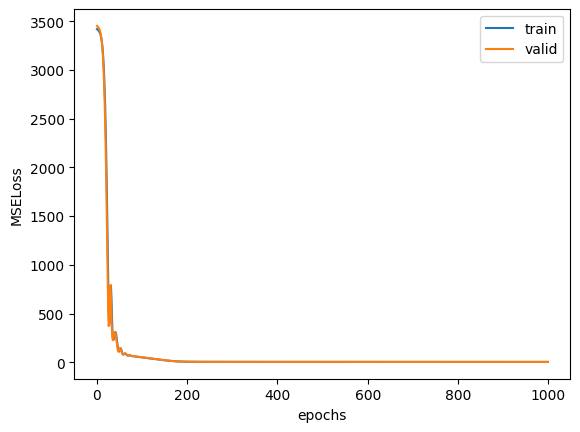

In [143]:
import torch
import torch.nn as nn
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

class FeedForwardNN(nn.Module):
  def __init__(self, in_features, out_features = 1,  hiden_layer = 128):
    super().__init__()
    self.ffn = nn.Sequential(nn.Linear(in_features, hiden_layer), nn.LeakyReLU(),
                             nn.Linear(hiden_layer, hiden_layer), nn.LeakyReLU(), 
                             nn.Linear(hiden_layer, hiden_layer), nn.LeakyReLU(),
                             nn.Linear(hiden_layer, hiden_layer), nn.LeakyReLU(),
                             nn.Linear(hiden_layer, hiden_layer), nn.LeakyReLU(),
                             nn.Linear(hiden_layer, out_features))
  def forward(self,x):
    return self.ffn(x).squeeze()

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), X_train.columns)])
X_train_tens = torch.tensor(preprocessor.fit_transform(X_train)).float()
y_train_tens = torch.tensor(y_train.values).float()
X_valid_tens = torch.tensor(preprocessor.transform(X_valid)).float()
y_valid_tens = torch.tensor(y_valid.values).float()


model = FeedForwardNN(in_features = X_train_tens.shape[1])
optimizer = Adam(model.parameters(), lr = 0.001)
loss_fn = MSELoss()

train_stats = []
valid_stats = []
epochs = []

for epoch in range(1000):

  model.train()
  optimizer.zero_grad()
  loss = loss_fn(model(X_train_tens), y_train_tens)
  loss.backward()
  optimizer.step()
  train_stats.append(loss.item())
    
  model.eval()
  with torch.no_grad():
    loss = loss_fn(model(X_valid_tens), y_valid_tens)
    valid_stats.append(loss.item())
  epochs.append(epoch)

plt.plot(epochs, train_stats, label="train")
plt.plot(epochs, valid_stats, label="valid")
plt.xlabel("epochs")
plt.ylabel("MSELoss")
plt.legend()
plt.show()

In [145]:
preds = model(torch.tensor(preprocessor.transform(X_test)).float()).detach().numpy()

print(f"FFN MSE: {mse(y_test, preds)}") # give no upgrade

FFN MSE: 4.399898384910447
